In [1]:
import numpy as np
from scipy.optimize import newton
from scipy.linalg import solve

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams["animation.embed_limit"] = 100
plt.rcParams["figure.dpi"] = 120
plt.ioff()

from IPython.display import HTML

### Simulation des Doppelpendels mit RATTLE

Wir betrachten ein ebenes Doppelpendel im $\mathbb{R}^2$ mit Pendellängen $L_1 = L_2 = L$ und Massen $m_1, m_2$. 
Die Koordinaten der beiden Massen seien $\mathbf{q}_1 = (x_1, y_1)$ bzw. $\mathbf{q}_2 = (x_2, x_1)$, die wir
im Vektor $\mathbf{q} = {(\mathbf{q}_1, \mathbf{q}_2)}^T = {(x_1,y_1,x_2,y_2)}^T \in \mathbb{R}^4$ zusammenfassen.

In [2]:
L = 2.4
m1 = 2.5
m2 = 2

# Startbedingungen
q0 = np.array([1/np.sqrt(2)*L, 1/np.sqrt(2)*L, np.sqrt(2)*L, np.sqrt(2)*L])
v0 = np.array([0,0,0,0])

Die Beziehung der beiden Pendelmassen kann über die folgenden holonomen Zwangsbedingungen beschrieben werden
\begin{align*}
{\|\mathbf{q_1}\|}^2 - L^2 &= 0 \\
{\|\mathbf{q_2} - \mathbf{q_1}\|}^2 - L^2 &= 0\,.
\end{align*}
Wir fassen diese beiden Bedingungen in einer Funktion $\mathbf{g} : \mathbb{R}^4 \rightarrow \mathbb{R}^2$ zusammen, d.h.
$$
\mathbf{g}(\mathbf{q}) = \mathbf{g}(\mathbf{q}_1, \mathbf{q}_2) = 
\begin{pmatrix}
{\|\mathbf{q_1}\|}^2 - L^2 \\
{\|\mathbf{q_2} - \mathbf{q_1}\|}^2 - L^2 
\end{pmatrix}
=
\begin{pmatrix}
x_1^2 + y_1^2 - L^2 \\
{(x_2 - x_1)}^2 + {(y_2 - y_1)}^2  - L^2 
\end{pmatrix}
$$
Die Jacobi-Matrix $\mathbf{G}(\mathbf{q})$ von $\mathbf{g}(\mathbf{q})$ ist dann 
$$
\mathbf{G}(\mathbf{q}) = 
\begin{pmatrix}
2 x_1 & 2 y_1 & 0 & 0 \\
-2(x_2 - x_1) & -2(y_2 - y_1) & 2(x_2 - x_1) & 2(y_2 - y_1)
\end{pmatrix}\,.
$$

In [3]:
def g(q):
    x1, y1, x2, y2 = q
    return np.array([x1**2 + y1**2 - L**2, (x2 - x1)**2 + (y2-y1)**2 - L**2])
        
def G_Jac(q):
    x1, y1, x2, y2 = q
    return np.array([[2*x1, 2*y1, 0, 0], [-2*(x2 - x1), -2*(y2-y1), 2*(x2-x1), 2*(y2-y1)]])

Damit können wir nun die Bewegungsgleichungen des Systems angeben. Das Potential $V : \mathbb{R}^4 \rightarrow \mathbb{R}$
ist das Gravitationspotential und ist gegeben durch
$$
V(\mathbf{q}) = V(x_1,y_1,x_2,y_2) = a(m_1 y_1 + m_2 y_2)\,,
$$
wobei $a = 9.81$ die Erdbeschleunigung angibt. Es ist also
$$
\nabla_{\mathbf{q}}V(\mathbf{q}) = \begin{pmatrix} 0 \\ am_1 \\ 0 \\ am_2 \end{pmatrix}\,
$$
und insgesamt erhalten wir die Bewegungsgleichungen
\begin{align}
\mathbf{M} \ddot{\mathbf{q}} &= - \nabla_{\mathbf{q}}V(\mathbf{q}) - \mathbf{G}(\mathbf{q})^T {\lambda} \\
\mathbf{g}(\mathbf{q}) &= \mathbf{0}\,,
\end{align}
wobei $\lambda = {(\lambda_1, \lambda_2)}^T$ die unbekannten Lagrange-Multiplikatoren sind und $\mathbf{M} = \text{diag}(m_1,m_1,m_2,m_2)$ die Massen-Matrix ist.

Die Idee des RATTLE-Algorithmus ist es, zunächst die Zwangsbedingungen zu ignorieren und einen Zeitschritt
mithilfe des Verlet-Algorithmus durchzuführen. Anschließend werden Position und Geschwindigkeit so korrigiert,
dass die Zwangsbedingung (zumindest näherungsweise) erfüllt ist. Dazu müssen wir jedoch zunächst eine Zwangsbedingung
für die Geschwindigkeit $\dot{\mathbf{q}}$ aus der obigen Zwangsbedingung herleiten. Diese erhält man durch
Ableiten der Zwangsbedingung für die Position. Es ergibt sich
$$
\mathbf{G}(\mathbf{q}) \cdot \dot{\mathbf{q}} = \mathbf{0}\,.
$$
Um auch diese Bedingung zu Erfüllen, führen wir zwei zusätzliche Lagrange-Multiplikatoren $\mu_1$ und $\mu_2$ ein.

<!-- Schreiben wir $\mathbf{v} = \dot{\mathbf{q}}$, dann lautet der RATTLE-Algorithmus wie folgt: Wiederhole in jedem Zeitschritt die Schritte:
1. Berechne $\mathbf{v}^{(n+1/2)}$ und $\mathbf{q}^{(n+1)}$ zunächst ohne die Zwangsbedingungen zu beachten.
2. Berechne iterativ Korrekturen von $\mathbf{v}^{(n+1/2)}$ und $\mathbf{q}^{(n+1)}$, durch iterative Korrektur der Lagrange-Multiplikatoren $\lambda$.
   Unten verwenden wir eine iterative Methode, die darauf basiert, die Zwangsbedingungen zu Linearisieren und sie dann mit einem iterativen Löser für linear Systeme zu lösen.
   Die unten implementierten Gleichungen entstehen, wenn ein Gauß-Seidel-Löser verwendet wird. Dieser Schritt wird so lange durchgeführt, bis die Zwangsbedingungen hinreichend gut erfüllt sind.
3. Berechnen nun mithilfe des korrigierten Wertes von $\mathbf{q}^{(n+1)}$ die Geschwindigkeit $\mathbf{v}^{(n+1)}$, zunächst wieder ohne Einbeziehen der Zwangsbedingungen.
4. Korrigiere nun iterativ $\mathbf{v}^{(n+1)}$ durch iterative Korrektur der Lagrange-Multiplikatoren $\mu$. -->

In [4]:
''' Die Parameter sind:
    q0  : Array, Anfangswert für die Position in der Form [x_1, y_1, x_2, y_2]
    v0  : Array, Anfangswert für die Geschwindigkeit (Reihenfolge analog wie Position)
    m1  : Pendelmasse des ersten Pendels
    m2  : Pendelmasse des zweiten Pendels
    L   : Länge der Pendel
    t0  : Startzeit
    t1  : Endzeit
    N   : Anzahl der Zeitschritte (d.h. delta_t = (t1 - t0) / (N-1))
    tol : Toleranz für die iterative Bestimmung der Zwangsbedingungen
'''
def RATTLE_doppelpendel(q0, v0, m1, m2, L, t0, t1, N, tol=10e-12):
    delta_t = (t1 - t0) / (N-1)
    grav = 9.81 # Gravitationskonstante
    
    Minv  = np.diag([1/m1, 1/m1, 1/m2, 1/m2])
    gradV = np.array([0, grav*m1, 0, grav*m2])
    
    q      = np.empty((N,4))
    v      = np.empty((N,4))
    v_half = np.empty((N,4))
    
    q[0]      = q0
    v[0]      = v0
    v_half[0] = v0 - 0.5*delta_t*Minv@gradV
    
    mu = np.array([0,0])
    
    for n in range(N-1):
        Gqn = G_Jac(q[n])

        k = 0
        qbar = q[n] + delta_t*v[n] - 0.5*delta_t**2 * Minv @ gradV
        while np.linalg.norm(g(qbar)) > tol:
            R = G_Jac(qbar) @ Minv @ Gqn.T
            lam = solve(R,g(qbar))
            qbar = qbar - Minv @ Gqn.T @ lam
            
            k = k+1
            if k == 500:
                print(f"Nicht konvergiert (|g(Q)| = {np.linalg.norm(g(qbar))}")
                break
        
        q[n+1] = qbar
        v_half[n+1] = (q[n+1] - q[n])/delta_t
        
        # Bestimme Lagrange-Multiplikatoren \mu für Geschwindigkeits-Zwangsbedingung
        Gqn_1 = G_Jac(q[n+1])
        rhs  = Gqn_1 @ (2/delta_t * v_half[n+1] - Minv @ gradV)
        mu   = solve(Gqn_1 @ Minv @ Gqn_1.T, rhs)
             
        v[n+1] = v_half[n+1] - 0.5*delta_t*Minv@(gradV + Gqn_1.T @ mu)
        
    return q,v

Wir können nun eine Beispielsimulation durchführen.

In [5]:
t0 = 0
t1 = 45

delta_t = 0.03
N = round((t1-t0)/delta_t + 1)

q,v = RATTLE_doppelpendel(q0,v0,m1,m2,L,t0,t1,N)

Im Plot wollen wir auch die Gesamtenergie des Systems angeben, welche in der folgenden Funktion berechnet wird.

In [6]:
def E(q,v):            
    # Kinetische Energie
    M = np.diag([m1,m1,m2,m2])
    T = 0.5*v@M@v
        
    # Potentielle Energie
    y1 = q[1]
    y2 = q[3]
    V  = 9.81*(y1*m1 + y2*m2)
    
    return T + V

Um zu sehen, dass das Verfahren von zweiter Ordnung ist, simulieren wir dasselbe Problem für verschiedene Zeitschritte.

Starte Simulation für delta_t = 0.08...Fertig.
Starte Simulation für delta_t = 0.04...Fertig.
Starte Simulation für delta_t = 0.02...Fertig.
Starte Simulation für delta_t = 0.01...Fertig.
Starte Simulation für delta_t = 0.005...Fertig.
Starte Simulation für delta_t = 0.0025...Fertig.


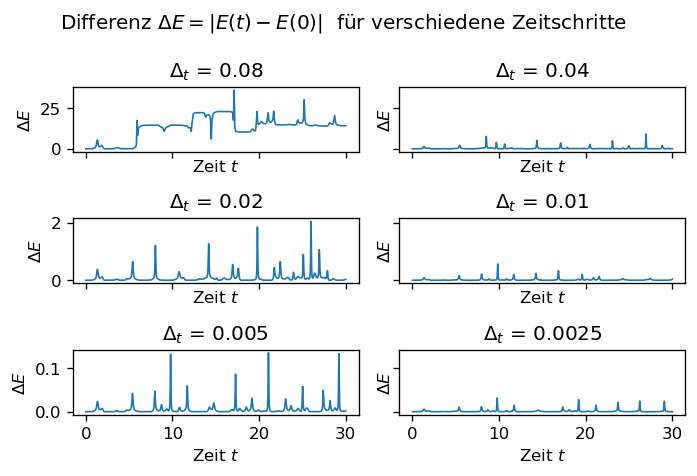

In [7]:
# Energieerhaltung prüfen
E0 = E(q0,v0)
fig,axs = plt.subplots(3,2, sharex='all', sharey='row')
fig.suptitle("Differenz $\Delta E = |E(t) - E(0)|$  für verschiedene Zeitschritte")

t0 = 0
t1 = 30
# Testprobleme für folgende delta_t
delta_ts = [0.08, 0.04, 0.02, 0.01, 0.005, 0.0025]
del_E = np.empty((len(delta_ts)))

for k, delta_t in enumerate(delta_ts):
    N = round((t1-t0)/delta_t + 1)
    ts = np.linspace(t0,t1,N)

    print(f"Starte Simulation für delta_t = {delta_t}...", end='')
    q,v = RATTLE_doppelpendel(q0,v0,m1,m2,L,t0,t1,N)
    print("Fertig.")
    
    E_error = np.empty((N))
    for i, (qi,vi) in enumerate(zip(q,v)):
        E_error[i] = E(qi,vi)-E0

    E_error = np.abs(E_error)
    del_E[k] = np.mean(E_error)
        
    ax = axs[k//2,k%2]
    
    ax.plot(ts, E_error, linewidth=1)
    ax.set_xlabel("Zeit $t$")
    ax.set_ylabel("$\Delta E$")
    #ax.plot([0,N], [E(q0,v0), E(q0,v0)], 'r-')
    ax.set_title(f"$\Delta_t$ = {delta_t}")
plt.tight_layout()
plt.show()

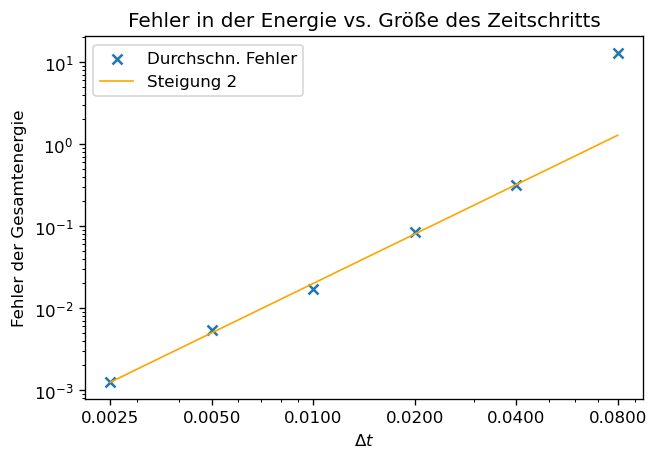

In [8]:
plt.figure()
plt.scatter(delta_ts, del_E, label="Durchschn. Fehler", marker='x')
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Fehler der Gesamtenergie")
ax.set_xlabel("$\Delta t$")

x0 = delta_ts[0]
x1 = delta_ts[-1]

y = lambda x : 200*x*x

y0 = y(x0)
y1 = y(x1)

ax.loglog([x0,x1], [y0,y1], color='orange', label="Steigung 2", linewidth=1)
ax.set_xticks(delta_ts)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

plt.title("Fehler in der Energie vs. Größe des Zeitschritts")
plt.legend()
plt.show()

In [9]:
# Achtung: Das Ausführen dieser Zelle dauert sehr lange (~1 Stunde)

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal',
                     autoscale_on=False,
                     xlim=(-5,5), ylim=(-5,5))

ims = []
for i, (qi, vi) in enumerate(zip(q,v)):
    (x1,y1,x2,y2) = qi
    (v1x,v1y,v2x,v2y) = vi
    
    im1, = ax.plot([0,x1],[0,y1], '-ko', animated=True, markersize=5*m1, mec='orange', mfc='orange', markevery=[1], linewidth=1)
    im2, = ax.plot([x1,x2],[y1,y2], '-ko', animated=True, markersize=5*m2, mec='orange', mfc='orange', linewidth=1)
    # im3  = ax.arrow(x1,y1,v1x,v1y, color='red')
    # im4  = ax.arrow(x2,y2,v2x,v2y, color='red')
    
    imt1 = ax.text(-4, 4, f"Zeit: {delta_t * i :.2f}s")
    imt2 = ax.text(-4, 3.2, f"Energie: {E(qi,vi) : .2f}J")
    
    ims_curr = [im1,im2,imt1,imt2]
    trace_N = 40
    for k,qk in enumerate(q[max(i-trace_N,0): i]): # Zeige letzte paar Punkte
        im_tr, = ax.plot(qk[2], qk[3], color='grey', marker='o', ms=0.8, alpha=(0.2 +  k/trace_N*0.8), animated=True)
        ims_curr.append(im_tr)
    ims.append(ims_curr)
    
interval = (t1 - t0)/(N-1)
    
ani = animation.ArtistAnimation(fig, ims, interval=delta_t,
                                blit=True)
plt.close(fig)

# ani.save('double_pendulum.mp4', writer='ffmpeg', fps=1/delta_t);
# HTML(ani.to_jshtml(fps=1/delta_t))